In [1]:
import numpy as np
import cvxpy as cp
import osbdo as ob

In [2]:
import time
import random


np.random.seed(0)
random.seed(0)

# Problem description
section 4.1 in https://web.stanford.edu/~boyd/papers/os_bundle_distr_opt.html 

# Create parameters

In [3]:
ms = [2, 5, 2, 3, 6]
ns = [5, 2, 3, 6, 5]
params = ob.sc_params(ms, ns)

# Distributed solution

In [4]:
agents = ob.sc_agents(params)
g = ob.sc_coupling(params, agents)
prob = ob.Problem(agents = agents, g = g)

In [5]:
max_iter = 150
start_time = time.time()
x_agent, x_global = prob.solve(rel_gap=10**(-5), abs_gap=10**(-5), max_iter=max_iter, memory=max_iter, print_freq=20)
print(f"elapsed time = {time.time() - start_time}")

k=0, rel_gap=inf, L=-19.522970897904557, U=245.16392110644114, L0=-19.522970897904557
k=20, rel_gap=inf, L=-0.05874637686287032, U=0.4267914266634134, L0=-0.05874637686287032
rho=44.00774974444514


/var/folders/13/wyn3w3nx7ks002_qzk18rz7h0000gn/T/ipykernel_15035/1978256884.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  x_agent, x_global = prob.solve(rel_gap=10**(-5), abs_gap=10**(-5), max_iter=max_iter, memory=max_iter, print_freq=20)
/Users/parshakova.tanya/opt/anaconda3/envs/osbdo/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


rel_gap=inf, L=-6.326977036380671e-09, U=8.539059442694008e-07
elapsed time = 11.079317092895508


# Centralized solution

In [6]:
h_cvx, x_cvx, prob_cvx = ob.cvx_supply_chain(params=params)

In [7]:
h_cvx, prob.upper_bnd[-1]

(2.234255981447417e-11, 8.539059442694008e-07)

# Plot

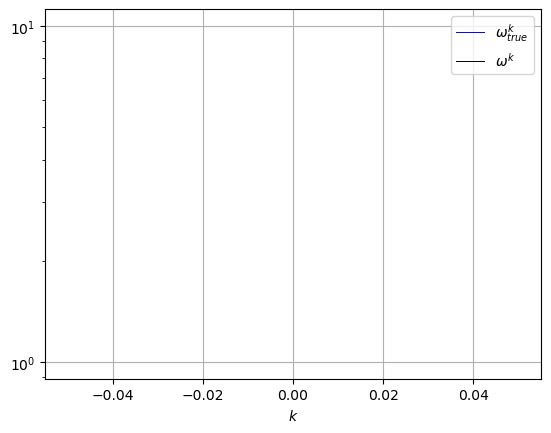

In [8]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx)

In [9]:
A, b, l, u, _, grad_g_val = ob.sc_data_matrix_format(params)

In [10]:
data = {"params" : params, "A": A, "b": b.reshape(-1, 1), "grad_g_val" : grad_g_val.reshape(-1, 1), "lower_bound" : l.reshape(-1, 1), "upper_bound" : u.reshape(-1, 1), "h_cvx":h_cvx}

In [11]:
import pandas as pd

pd.to_pickle(data, "sc_data_small.pickle")

In [12]:
l, u, grad_g_val

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([ 3.12767879,  9.59534879,  1.84040191,  3.17812036,  1.64910119,
         5.33159147,  3.53306587,  1.84040191,  3.17812036,  1.64910119,
         5.33159147,  3.53306587,  6.08047679,  4.09229414,  6.08047679,
         4.09229414, 13.52191579,  7.81929729, 10.59553966, 13.52191579,
         7.81929729, 10.59553966,  6.55920779, 10.18812278, 10.94050711,
        13.87046479, 10.92997087,  9.08870515,  6.55920779, 10.18812278,
        10.94050711, 13.87046479, 10.92997087,  9.08870515,  6.70544272,
         9.04804683, 12.53820285,  4.91593991, 28.36934618]),
 array([  9.09762701,   9.43037873,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0

In [13]:
h_cvx

2.234255981447417e-11

In [15]:
def cvx_supply_chain(*, params, grad_g_val, norm="l1", x_val=None):
    """
    params: parameters for OT agents

    Returns the true solution to the distributed optimization problem
    of  Optimal Transport using CVXPY and  centralised formulation
        min. \sum_i  f_i(xi)
        s.t. Ax = b,
             Cx <= d   
    """
    N = len(params)
    x_size = sum([params[i]["dimension"] for  i in range(1, N-1)])
    A, b, l, u, idx = ob.sc_data_matrix_format(params)[:5]
    idx = [params[0]['dimension'] - 1] + idx + [params[-1]['dimension']]
    
    mu = ob.get_mus(50, params[1:-1], N-2)
    z = cp.Variable((A.shape[1], ))
    f = 0
    constraints = []
    for i in range(1, N-1):
        xi = z[idx[i][0] : idx[i][1]+1]
        size = params[i]["dimension"]
        m, n = params[i]["m"], params[i]["n"]
        X = cp.Variable((n,m), nonneg=True)
        tilde_x = cp.Variable((size, ), nonneg=True)
        lin, quad, cap = params[i]["lin"], params[i]["quad"], params[i]["cap"]
        constraints += [ cp.hstack([cp.sum(X, axis=0), cp.sum(X, axis=1)]) == tilde_x]
        if cap.sum() < np.inf: constraints += [X <= cap]

        f += cp.vec(X) @ cp.vec(lin) + 0.5 * cp.vec(cp.power(X,2)) @ cp.vec(quad)
        r = cp.Variable((size, ))
        constraints += [ r == tilde_x - xi ]
        if norm == "l2":
            f += 0.5 * cp.sum_squares(np.diag(mu[i-1]**(0.5)) @ r)
        elif norm == "l1":
            f += 0.5 * cp.norm(np.diag(mu[i-1]) @ r, 1)
    obj = f + cp.vec(z) @ grad_g_val
    if x_val is not None:
        constraints += [z ==  x_val] 
    constraints += [A @ z == b, z <= u, z >= l]
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver='ECOS')
    return obj.value, z.value, prob 

In [16]:
 cvx_supply_chain(params=params, grad_g_val=grad_g_val)[0]

2.2342559814474176e-11